# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico IV : Aprendizaje no supervisado

# Introducción

En esta notebook haremos un análisis del dataset generado anteriormente, a través de técnicas y métodos que se corresponden con Aprendizaje no supervisado.

### Estructura
En una **primera parte** se realiza clustering (con Kmeans) y embeddings (con PCA) sobre el dataset usando todas las features originales, y se analizan los resultados.

En una **segunda parte** de esta notebook se realiza un análisis análogo pero se acota el espacio de features a las dos features correspondientes a cuestiones afectivas - las features `valence` y `lyrics_sentiment` - con el propósito de explorar la utilidad en estas features a la hora de analizar el dataset, para explorar si pueden considerarse relevantes a la hora de agrupar las canciones con algún criterio en común. Debido a los resultados obtenidos se ofrecen Trabajos Futuros, en donde en conjunto con más análisis afectivo/temático de los temas se podría mejorar los primeros intentos de desarrollar un clasificador de canciones -beyond "music genres" (if they ever existed). 

### Librerías

!pip3 install spotipy
!pip3 install pandas
!pip3 install spacy
!pip3 install pymusixmatch
!pip3 install nltk
!pip3 install sklearn

# Agregar las librerías extra que se utilicen en esta celda y la siguiente

In [2]:
import ast
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import warnings


client_id = '46b333d567314a89a6254b6c6b054be6'
client_secret = '9d922c3613e441518349dcf55f7d5853'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


## Funciones Generales

In [3]:
def print_kmeans_inertia(df, cluster_range=10):
    scores = [KMeans(n_clusters=i+2).fit(df).inertia_ for i in range(cluster_range)]

    plt.plot(np.arange(2, cluster_range + 2), scores)
    plt.xlabel('Number of clusters')
    plt.ylabel("Inertia")
    plt.title("Inertia of k-Means versus number of clusters")
    plt.show()
    
def get_df_songs(file_path = "./final_big.csv"):
    songs_base = pd.read_csv(file_path,sep="#")
    songs_base["genres"]=songs_base["genres"].apply(lambda x: x.replace("[","").replace("]","").replace("'","").split(","))
    songs_base["artists"]=songs_base["artists"].apply(lambda x: x.replace("[","").replace("]","").replace("'","").split(","))
    audio_thing= songs_base["audio_features"].apply(lambda x: ast.literal_eval(x))
    audio_features_base = pd.DataFrame(list(audio_thing))
    audio_features = audio_features_base.columns

    df_song_base = songs_base.reset_index(drop=True)
    audio_features_base = audio_features_base.reset_index(drop=True)
    df_song_base = pd.concat([df_song_base,audio_features_base],axis=1)
    return df_song_base

def scale_df_song(df, features_columns):
    df_features = df[features_columns]
    scaler = StandardScaler()
    df_scale = scaler.fit_transform(df_features)
    df_features_scale = pd.DataFrame(df_scale, columns=features_columns)
    df_features["song_name"]= df["song_name"]
    df_features["artists"]= df["artists"]

    df_features_scale["song_name"]=df["song_name"]
    df_features_scale["artists"]= df["artists"]

    
    return df_features, df_features_scale
    
def print_Silohuette(n_clusters, cluster_labels, df_skills, title):

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df_skills) + (n_clusters + 1) * 10])

    #cluster_labels = km.labels_

    silhouette_avg = silhouette_score(df_skills, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(df_skills, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))    
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #ax2.set_title("The visualization of the clustered data.")
    #ax2.set_xlabel("Feature space for the 1st feature")
    #ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle((title),
                 fontsize=14, fontweight='bold')

    plt.show()

    

### Dependencias y acceso a APIs

In [6]:
"""
Obtener features de audio
Obtener features de texto
Combinarlas en un DataFrame
"""
warnings.filterwarnings('ignore')
df_song_base = get_df_songs()
df_song_base.columns
features_columns = ['lyrics_sentiment', 'danceability', 'energy', 'key', 
                     'loudness', 'mode', 'speechiness', 'acousticness', 
                     'instrumentalness', 'liveness', 'valence', 'tempo']

df_features, df_features_scale = scale_df_song(df_song_base, features_columns)


X_unscaled = df_features
X_scaled = df_features_scale

/home/kunan/Documentos/famaf/diplodatos/datos/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kunan/Documentos/famaf/diplodatos/datos/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Elegir un número óptimo de clusters

En este punto buscaremos el número de clusters que queremos para correr K-means obteniendo los mejores resultados. Para esto utilizaremos dos criterios de selección:
- Primero, el "método del codo" (Elbow method). Este es una técnica (heurística) muy popular en el aprendizaje no supervisado que consiste en correr el algoritmo con diferentes cantidades __k__ de clusters, calculando para cada caso la suma de distancias cuadradas de cada punto al centro asignado para su cluster (PISTA: estos valores se pueden obtener como un atributo del clasificador luego de ajustarlo a __X_scaled__). Luego graficamos para cada __k__ el valor obtenido, esto nos dará un gráfico con forma de brazo (curva) en el cual el codo del mismo (el punto de inflexión de la curva) es un buen valor para __k__.
- Segundo, el [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) nos da un coeficiente que va de -1 (peor) a 1 (mejor) y que nos dice qué tan similar es un punto a los demás dentro de su cluster y qué tan diferente es de los puntos en el resto de los clusters. En este caso nos quedaremos con el valor de k que maximice el Silhouette score para __X_scaled__.

La tarea consiste en obtener para cada caso el k que de mejores resultados de acuerdo a los gráficos obtenidos.

<IPython.core.display.Javascript object>


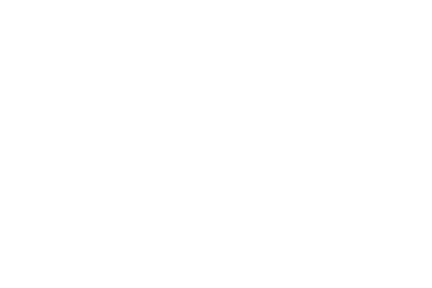

<IPython.core.display.Javascript object>


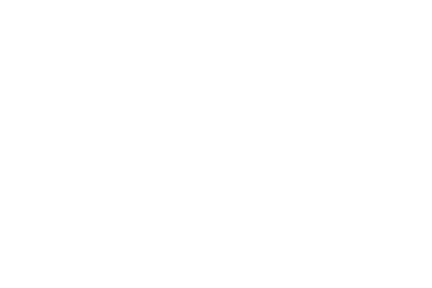

In [84]:
print_kmeans_inertia(X_scaled.drop(['artists','song_name'], axis=1), cluster_range=16)

<IPython.core.display.Javascript object>


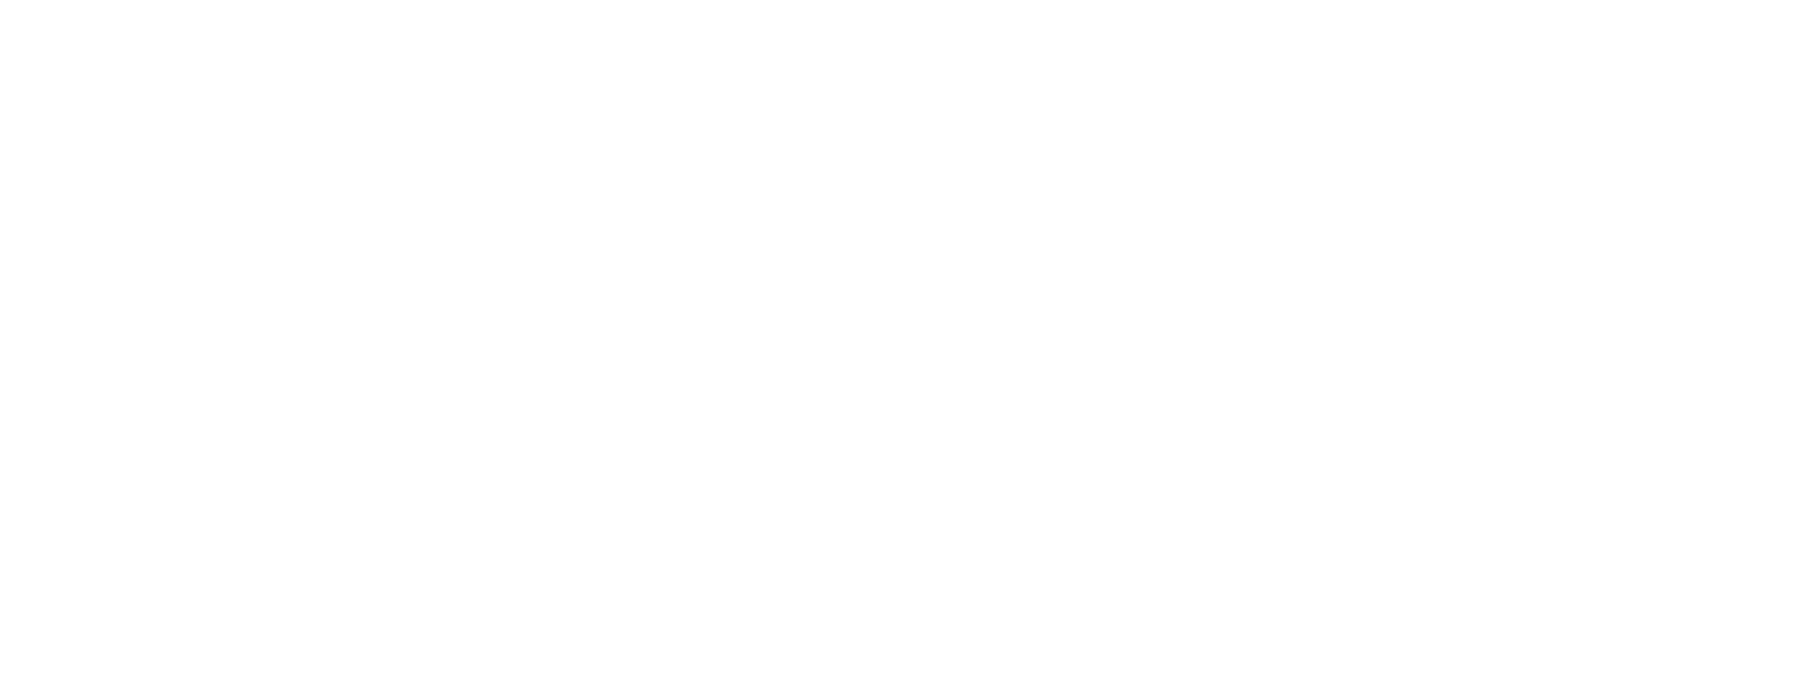

For n_clusters = 4 The average silhouette_score is : 0.13413146807236614


<IPython.core.display.Javascript object>


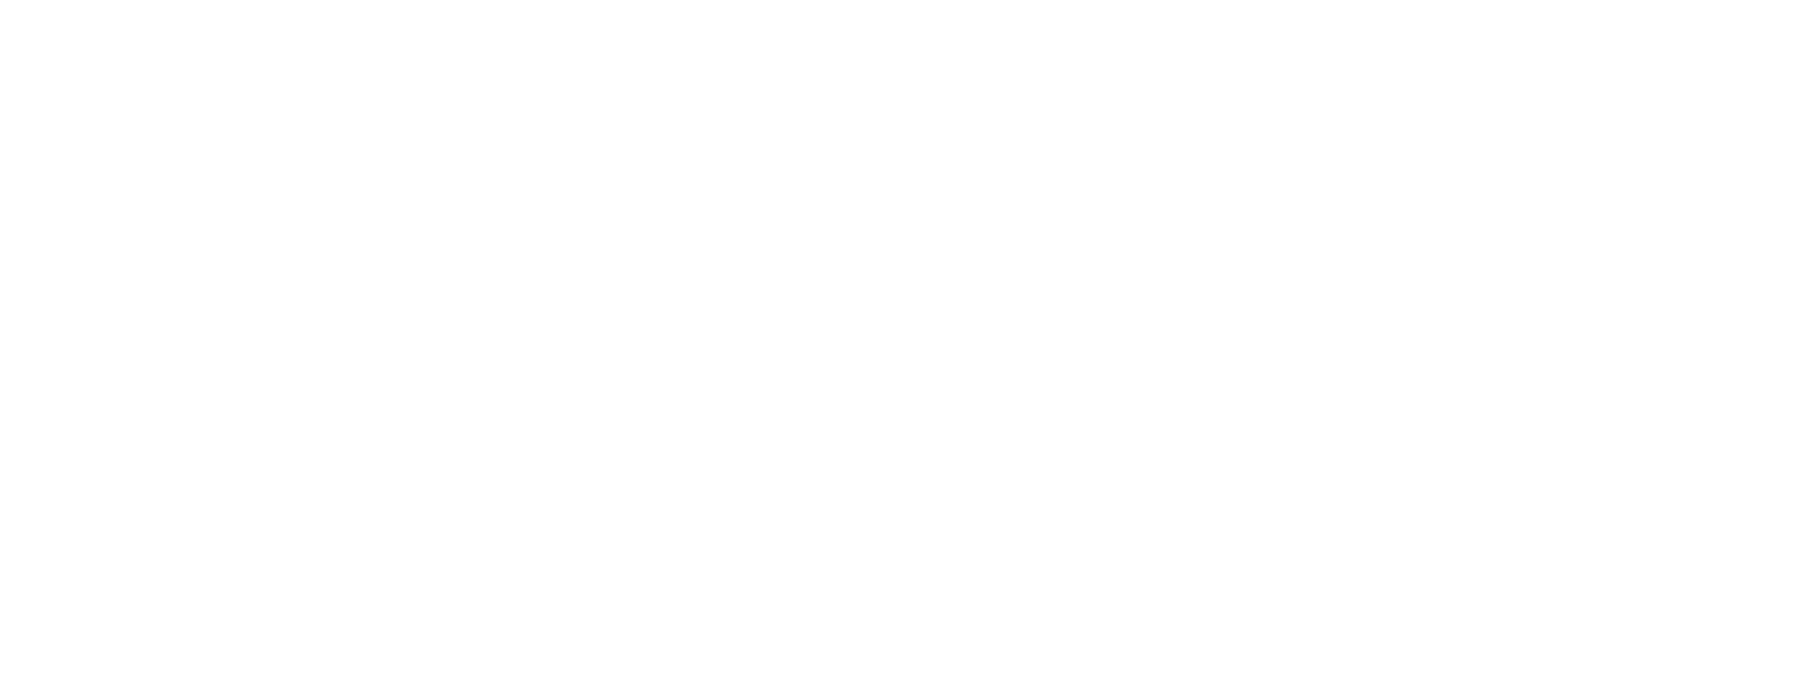

For n_clusters = 6 The average silhouette_score is : 0.13819261033199995


<IPython.core.display.Javascript object>


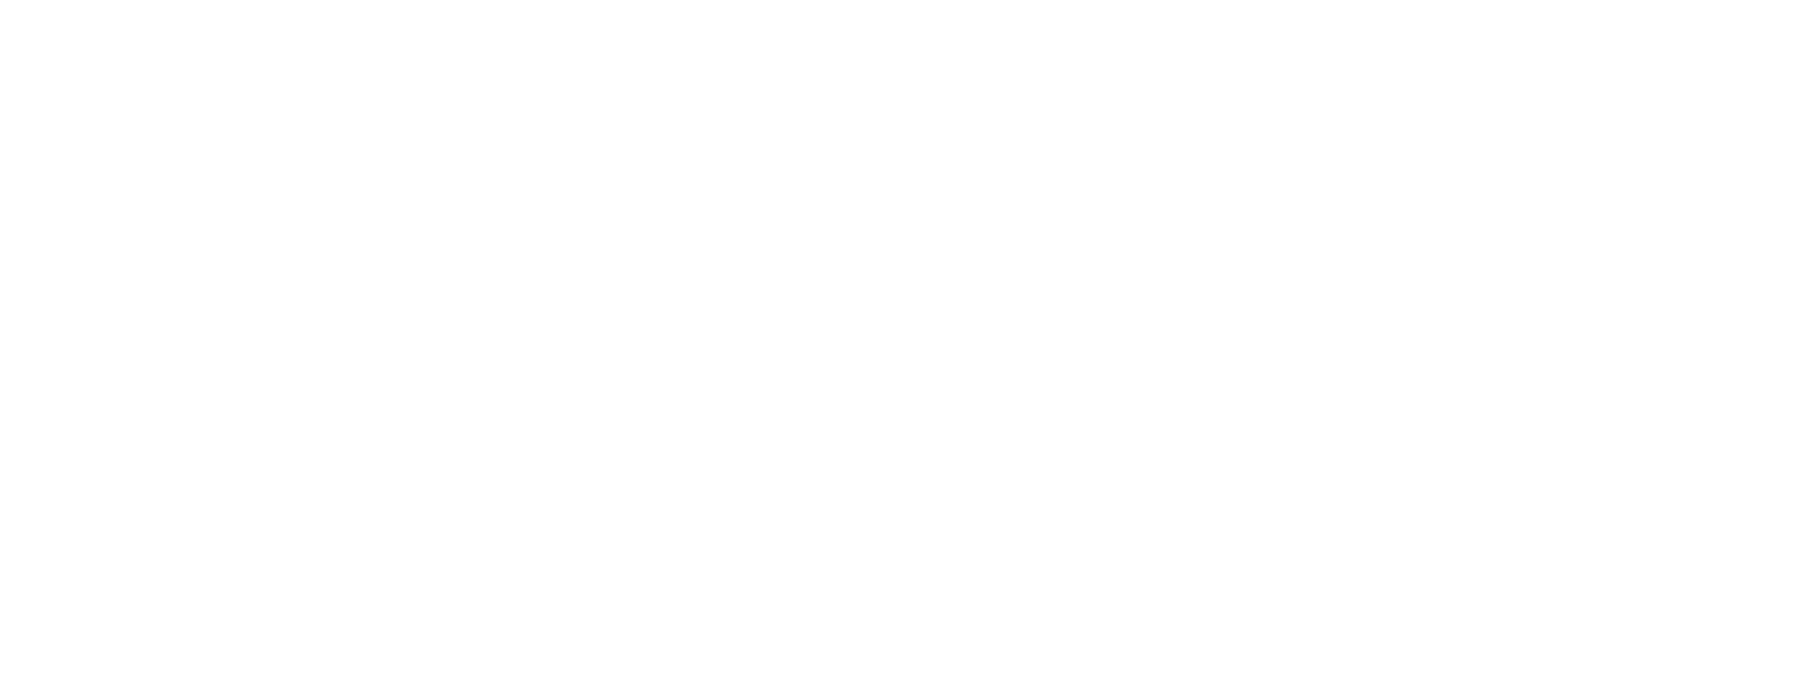

For n_clusters = 7 The average silhouette_score is : 0.13185394784978574


<IPython.core.display.Javascript object>


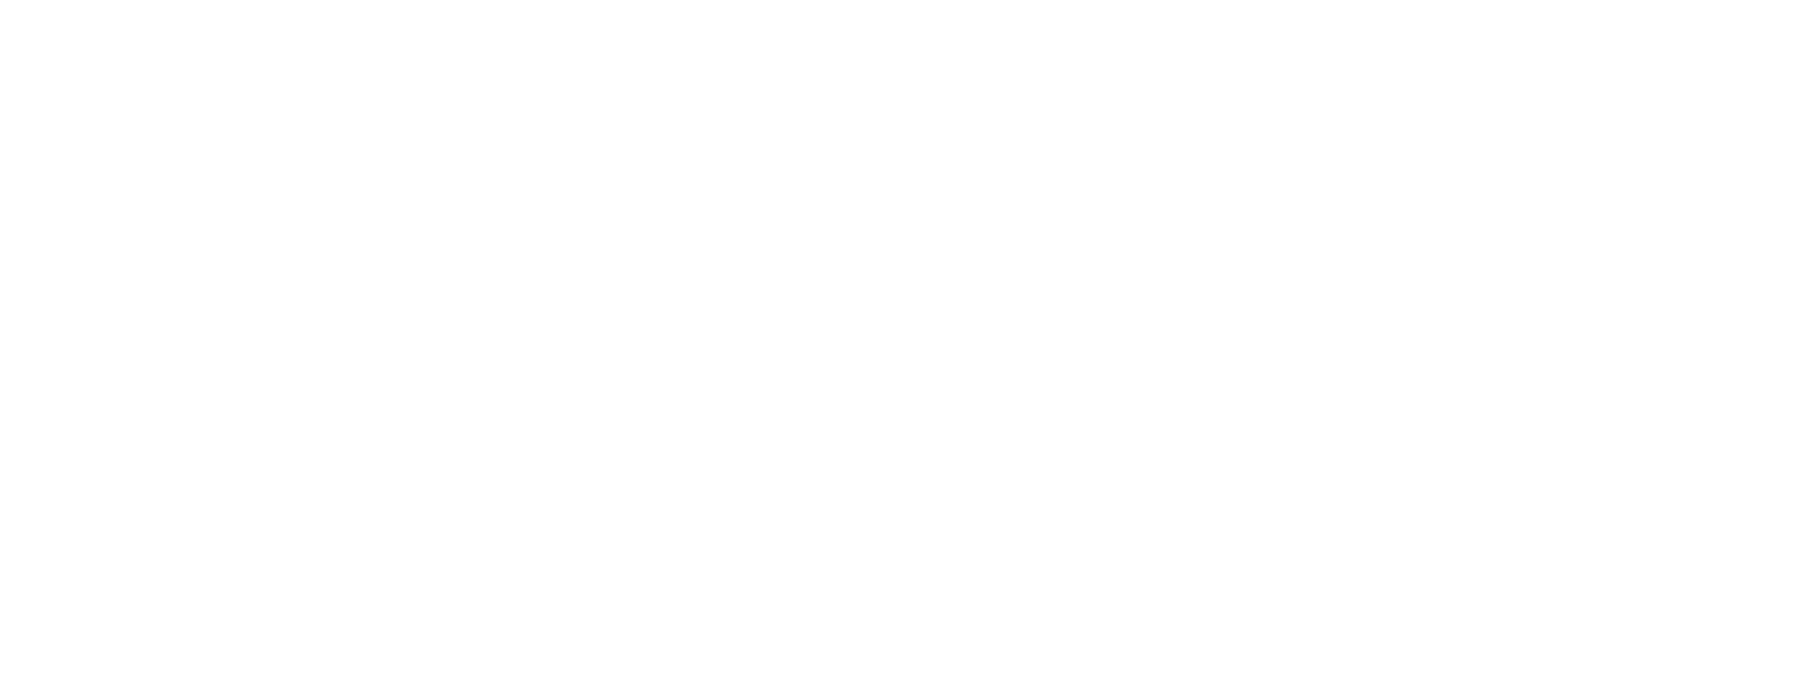

For n_clusters = 8 The average silhouette_score is : 0.13743350675838198


<IPython.core.display.Javascript object>


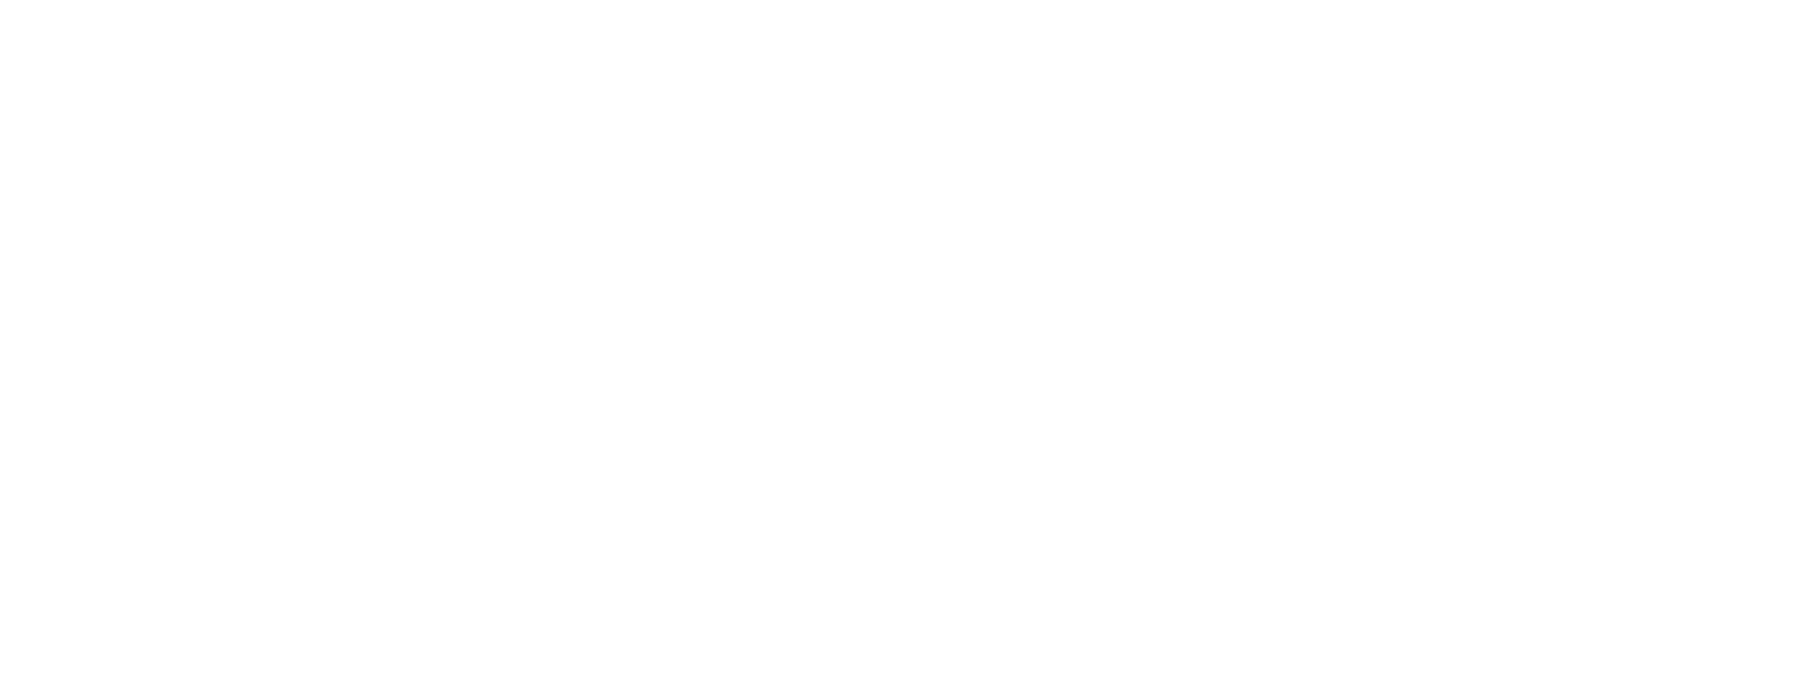

For n_clusters = 9 The average silhouette_score is : 0.13530150880851657


<IPython.core.display.Javascript object>


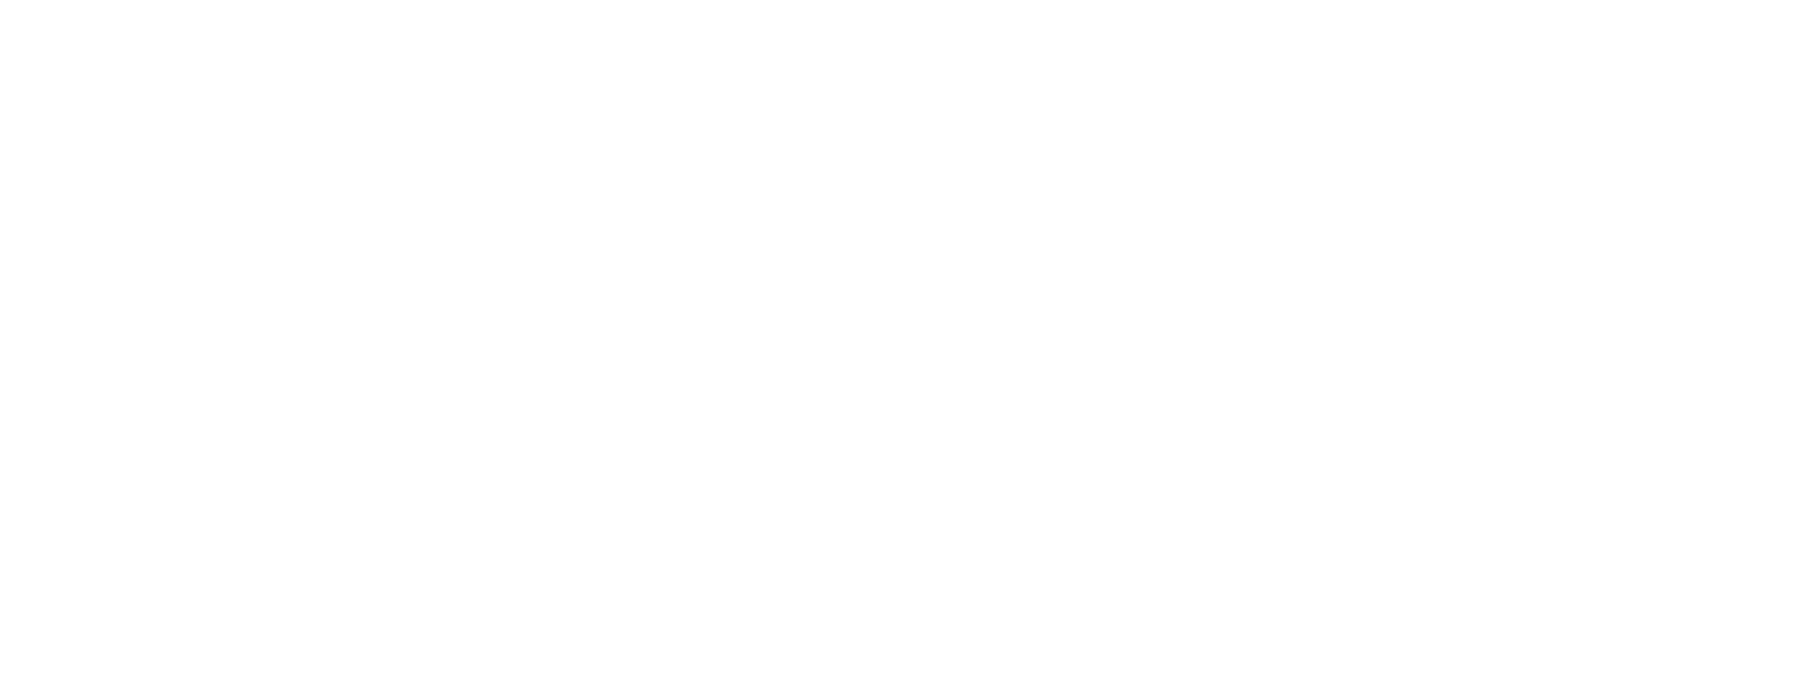

For n_clusters = 10 The average silhouette_score is : 0.12349126419681551


In [8]:
%matplotlib notebook

n_clusters_list = [4,6,7,8,9, 10]
for n in n_clusters_list:
    n_cluster_kmean =n
    km = KMeans(n_clusters=n_cluster_kmean, random_state=10)
    km.fit(X_scaled.drop(['artists','song_name'], axis=1))
    title = "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_cluster_kmean
    print_Silohuette(n_cluster_kmean, km.labels_, X_scaled.drop(['artists','song_name'], axis=1), title)



Los valores de k elegidos de acuerdo a estas dos reglas son:
- k1 = 4
- k2 = 8

### 3) Correr K-Means con los k elegidos

En este punto corremos de nuevo el algoritmo con los __k1__ y __k2__ elegidos en __2)__ y almacenaremos los resultados obtenidos en __X_preds_k1__ y __X_preds_k2__. Recuerden que el output de la predicción es un conjunto de __n__ (= #Canciones) etiquetas que nos dicen en qué cluster está cada canción __Xi__, por lo que deberán crear una tabla o mecanismo para obtener, además de las predicciones, los clusters como listas de canciones para cada __k__ elegido para su posterior análisis en el informe.

In [9]:
k1_nclusters = 4
k2_nclusters = 8
km_n_k1 = KMeans(n_clusters=k1_nclusters, random_state=10)
km_n_k2 = KMeans(n_clusters=k2_nclusters, random_state=10)

X_preds_k1 = km_n_k1.fit(X_scaled.drop(['artists','song_name'], axis=1)).labels_
X_preds_k2 = km_n_k2.fit(X_scaled.drop(['artists','song_name'], axis=1)).labels_

song_clusters_k1 = df_features_scale.copy()
song_clusters_k1['cluster'] = X_preds_k1

song_clusters_k2 = df_features_scale.copy()
song_clusters_k2['cluster'] = X_preds_k2

### 4) Graficar los clusters obtenidos

Para esta actividad utilizaremos las funciones __plot2D__ y __plot3D__ para graficar los clusters que obtuvimos en el ejercicio anterior. Previamente, se debe realizar una reducción de dimensiones al conjunto de datos __X_scaled__ para poder graficar los puntos dos y tres dimensiones, respectivamente. Por último, los colores de los puntos graficados estarán dados por cluster al que pertenece cada canción.

<IPython.core.display.Javascript object>


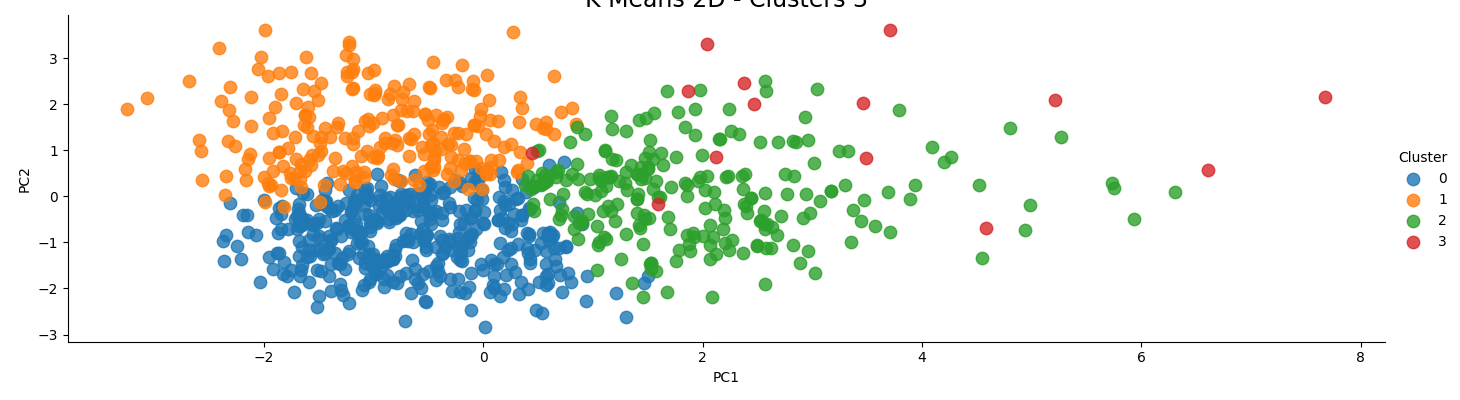

<IPython.core.display.Javascript object>


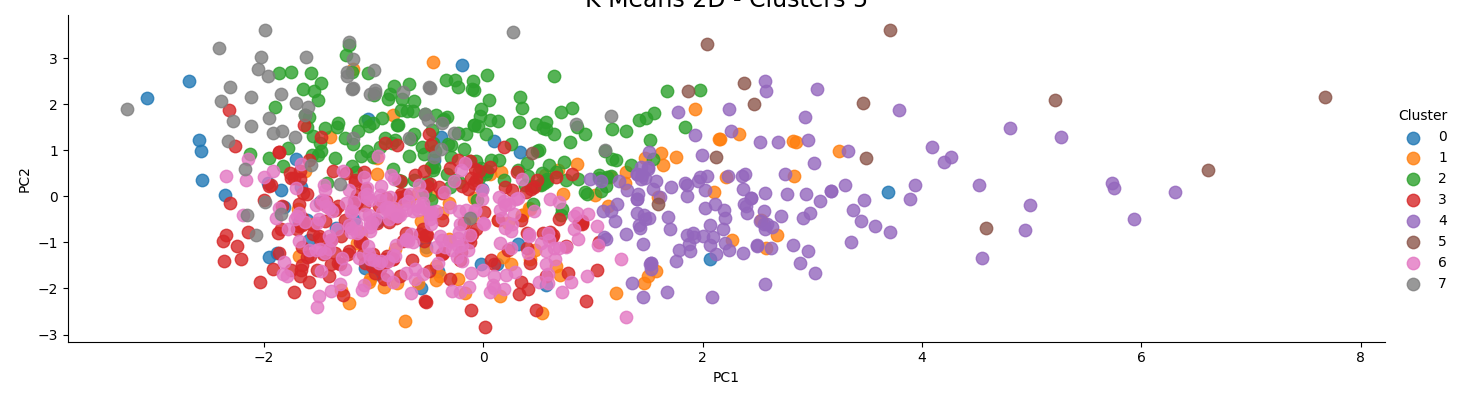

[]

In [31]:
%matplotlib notebook

pca_2D = decomposition.PCA(n_components=2, random_state=42)
pca_3D = decomposition.PCA(n_components=3, random_state=42)

pc_2D = pca_2D.fit_transform(X_scaled.drop(['artists','song_name'], axis=1))


df_pca_2D_k1 = pd.DataFrame(data=pc_2D, columns=['PC1', 'PC2'])
df_pca_2D_k1['Cluster'] = X_preds_k1

df_pca_2D_k2 = pd.DataFrame(data=pc_2D, columns=['PC1', 'PC2'])
df_pca_2D_k2['Cluster'] = X_preds_k2

sns.lmplot(x='PC1', y='PC2', data=df_pca_2D_k1,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("K Means 2D - Clusters {}".format(k1_nclusters), fontsize=17)

sns.lmplot(x='PC1', y='PC2', data=df_pca_2D_k2,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("K Means 2D - Clusters {}".format(k2_nclusters), fontsize=17)
plt.plot()

<IPython.core.display.Javascript object>


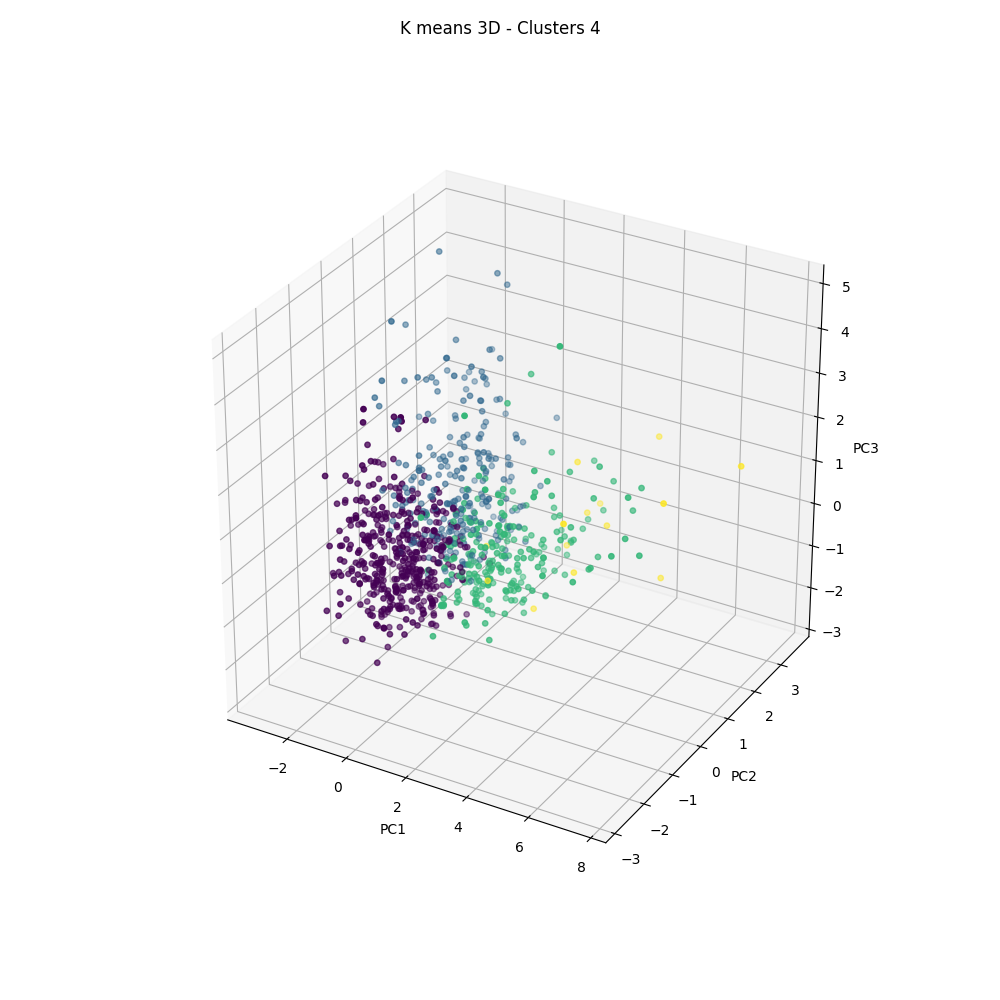

In [44]:
%matplotlib notebook

pca_3D = decomposition.PCA(n_components=3, random_state=42)

pc_3D = pca_3D.fit_transform(X_scaled.drop(['artists','song_name'], axis=1))

df_pca_3D_k1 = pd.DataFrame(data=pc_3D, columns=['PC1', 'PC2', 'PC3'])
df_pca_3D_k1['Cluster'] = X_preds_k1

fig = plt.figure(figsize=(10,10))
fig.suptitle('K means 3D - Clusters {}'.format(k1_nclusters))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca_3D_k1['PC1'], df_pca_3D_k1['PC2'], df_pca_3D_k1['PC3'], c=df_pca_3D_k1['Cluster'], s=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

<IPython.core.display.Javascript object>


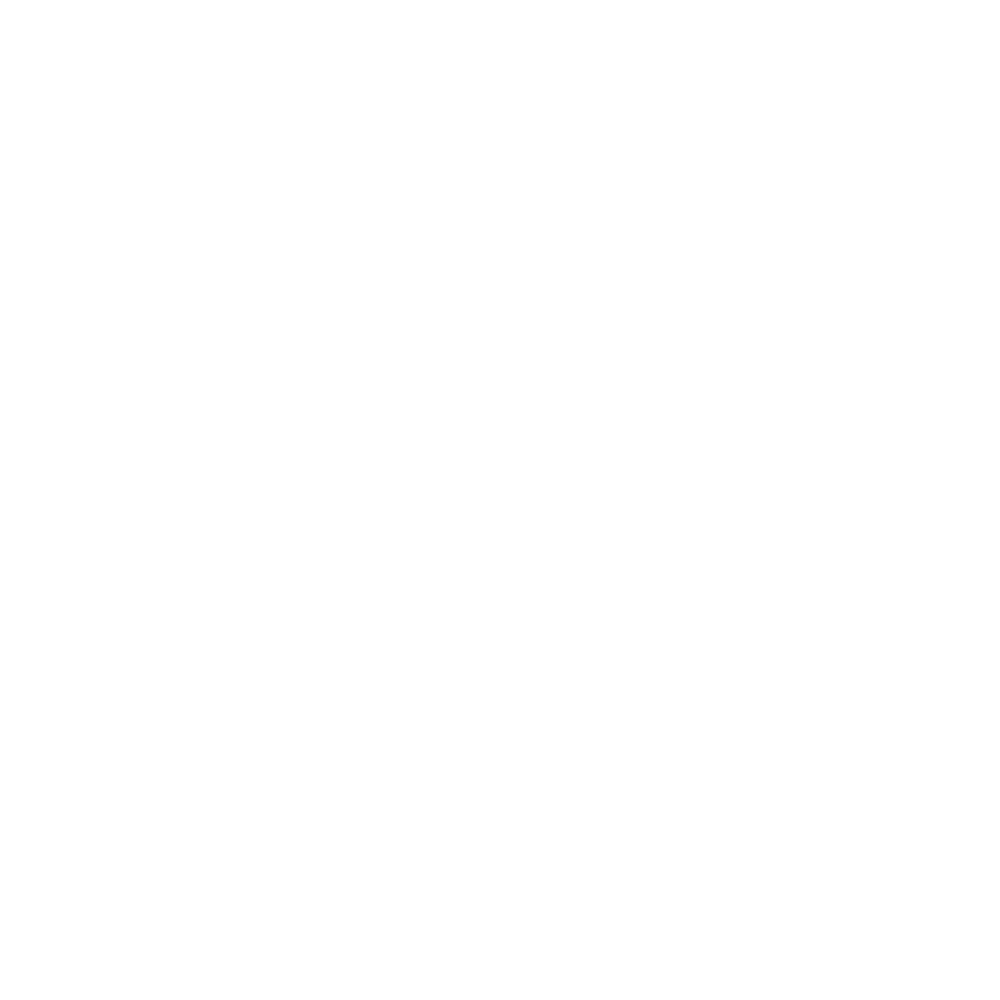

In [12]:
%matplotlib notebook

df_pca_3D_k2 = pd.DataFrame(data=pc_3D, columns=['PC1', 'PC2', 'PC3'])
df_pca_3D_k2['Cluster'] = X_preds_k2



fig = plt.figure(figsize=(10,10))
fig.suptitle('K means 3D - Clusters {}'.format(k2_nclusters))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca_3D_k2['PC1'], df_pca_3D_k2['PC2'], df_pca_3D_k2['PC3'], c=df_pca_3D_k2['Cluster'], s=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

### 5) Informe

Por último, deberán escribir un informe en el cual:
1. Muestren los clusters obtenidos en __3)__ como listas de canciones
2. Describan cualitativamente (e intuitivamente) estos clusters para cada __k__ elegido de acuerdo al contenido de los mismos, por ejemplo: 
    - El cluster 1 presenta canciones de géneros subsaharianos y es el más amplio debido a que..., el 2 de géneros tribales del cuerno de África, el 3...
    - Los clusters x0, x1, ... , xn no presentan algún patrón observable, pero xn+1 y xn+4 tienen...
4. Digan cuál k les dio resultados más coherentes y/o interpretables
5. Comparen los resultados obtenidos con aprendizaje no supervisado (con el mejor de los dos k) vs supervisado de manera cualitativa. Por ejemplo: nos parece mejor/peor/distinto/indistinto el modelo de aprendizaje no supervisado/supervisado en esta tarea porque...




## Análisis de Clústers

In [13]:
warnings.filterwarnings('ignore')
song_clusters_k1['artists'] = song_clusters_k1['artists'].apply(lambda x: pd.Series(x[0])).stack().reset_index(level=1, drop=True)
cluster_1 = song_clusters_k1[song_clusters_k1["cluster"] == 1]
cluster_2 = song_clusters_k1[song_clusters_k1["cluster"] == 2]
cluster_3 = song_clusters_k1[song_clusters_k1["cluster"] == 3]
cluster_4 = song_clusters_k1[song_clusters_k1["cluster"] == 0]


In [14]:
clusters = [cluster_1,cluster_2,cluster_3,cluster_4]
i = 1
for clus in clusters:
    print(f'El cluster {i} tiene {len(clus)} elementos')
    i += 1


El cluster 1 tiene 241 elementos
El cluster 2 tiene 235 elementos
El cluster 3 tiene 14 elementos
El cluster 4 tiene 430 elementos


In [15]:
cluster_1.sample(10)[["artists","song_name"]]

,artists,song_name
567,Los Piojos,Luz de Marfil
575,Los Piojos,Arco
215,Árbol,Comida Chatarra
294,2 minutos,Tema De Adrian
261,Hermetica,Prediccion
627,Callejeros,Si Me Cansé
282,Hermetica,Cambalache
776,Rodrigo,Informe Policial
753,Almafuerte,Buitres
205,Usted Señalemelo,Laser 420


In [16]:
cluster_2.sample(10)[["artists","song_name"]]

,artists,song_name
866,WOS,TERRAZA
909,Indios,Ya Pasó
100,La Mona Jimenez,Informe Policial
162,Luis Miguel,El Reloj
372,Viejas Locas,Me Gustas Mucho
447,Chayanne,Tiempo De Vals
726,Almafuerte,En Este Viaje
572,Los Piojos,Canción de Cuna
465,Chayanne,Daría Cualquier Cosa
460,Chayanne,Quisiera Ser


In [17]:
cluster_3.sample(10)[["artists","song_name"]]

,artists,song_name
263,Hermetica,Horizonte Perdido
918,Bandalos Chinos,Ácido
253,Eruca Sativa,Umbral
725,Almafuerte,Caballo negro
882,El Mató a un Policía Motorizado,Postales Negras
0,Arca,Desafío
887,El Mató a un Policía Motorizado,La Sintesis O'Konor
200,El Mató a un Policía Motorizado,La Casa Fantasmal
225,Eruca Sativa,Intropía
886,El Mató a un Policía Motorizado,Las Luces


In [18]:
cluster_4.sample(10)[["artists","song_name"]]

,artists,song_name
211,Árbol,Pequeños Sueños
670,Ozuna,Baila Baila Baila - Remix
665,Lunay,Soltera - Remix
350,La Beriso,Traicionero
107,La Mona Jimenez,Sé que te enamorarás
202,Usted Señalemelo,Pana
815,Sabroso,Pensando en Ti
618,Calle 13,Se Vale To-To
490,La Oreja de Van Gogh,Te Pareces Tanto a Mí
229,Eruca Sativa,Justo al Partir


In [54]:
df = song_clusters_k1.copy()
df_by_artist = df.set_index('artists')

#artistas destacados a seguir
artists = ["Luis Miguel", "Arca", "Hermetica", 
           "WOS", "Los Piojos", "Árbol", "Damas Gratis", "Mala Fama", "La Mona Jimenez",
          "Los Piojos", "La Barra", "Rodrigo", "Raphael","Chayanne","Almafuerte",'Daddy Yankee']

def distrs_of_clusters_by_artists(artists_list=artists,df=df_by_artist): # [str] -> DataFrame -> [DataFrame]
    dists = []
    
    for artist in artists_list:
        artist_distr = pd.DataFrame(df[df.index.str.startswith(artist)]['cluster'],columns=["cluster"])
        artist_distr.index = np.arange(0, len(artist_distr))
        dists.append(artist_distr)
    return dists
dists = distrs_of_clusters_by_artists()

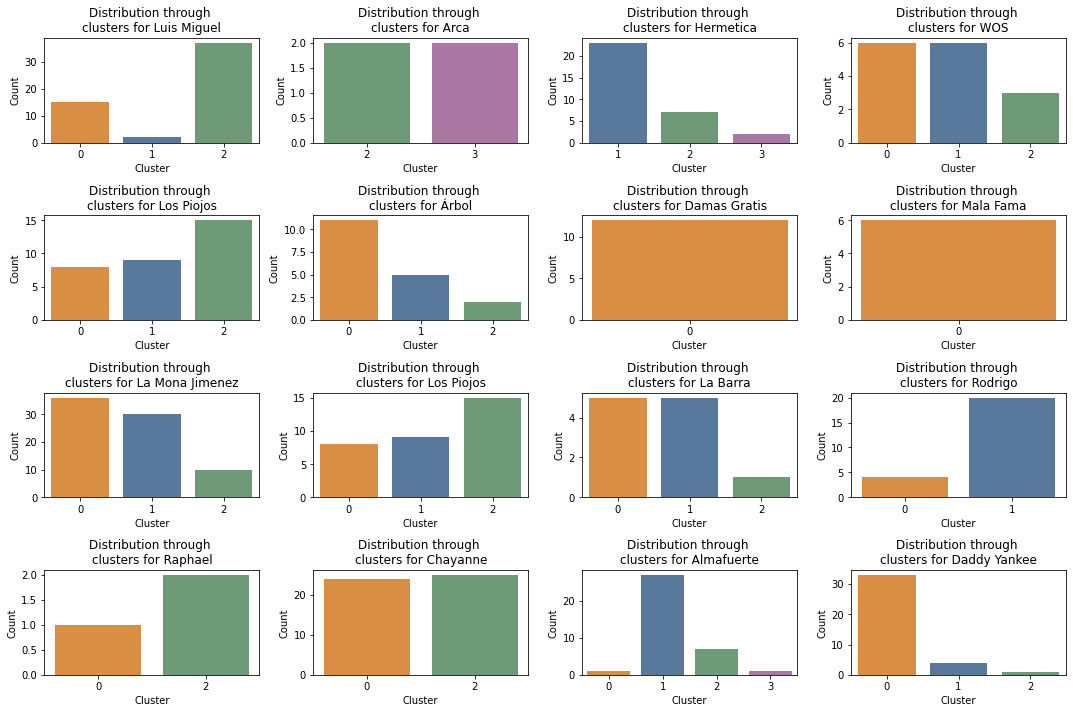

In [20]:
%matplotlib inline
i=0
colors = {0: "#F28E2B", 1: "#4E79A7", 2: "#68a172", 3: "#b370aa"}
fig, axs = plt.subplots(4, 4, figsize=(15,10))
for j in range(4):
    for k in range(4):
        sns.barplot(x=dists[i].cluster.value_counts().index,y=dists[i].cluster.value_counts(),ax=axs[j,k],palette=colors)
        axs[j,k].set_title(f'Distribution through \nclusters for {artists[i]}')
        i+=1

for ax in axs.flat:
    ax.set(xlabel='Cluster', ylabel='Count')
fig.tight_layout(pad=1.05)
plt.show()

## Aprendizaje no supervisado enfocado en sentiment features

Tenemos features relacionados a componentes afectivas de las canciones en el dataset. 

Es de especial interés ver qué conocimientos podemos derivar de estudiar estos componentes afectivos, con el fin de poder, en un futuro, incorporar estos distintos entendimientos a un modelo, para tener algoritmos más holísticos respecto a su "inteligencia".

Respecto a la computación afectiva Rosalind Picard afirma

> "The human brain, in both males and females, relies on emotion in normal thinking. In other words, even the most rational thinking requires participation from the emotion-mediating parts of the brain. Consequently, affective computers should not be considered more feminine, but more human." [Rosalind Picard - Affective Computing - 2000]


In [21]:
X_scaled.columns

Index(['lyrics_sentiment', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'song_name', 'artists'],
      dtype='object')

In [29]:
X_scaled_sentiment = X_scaled[['lyrics_sentiment','valence','song_name','artists']]

<IPython.core.display.Javascript object>


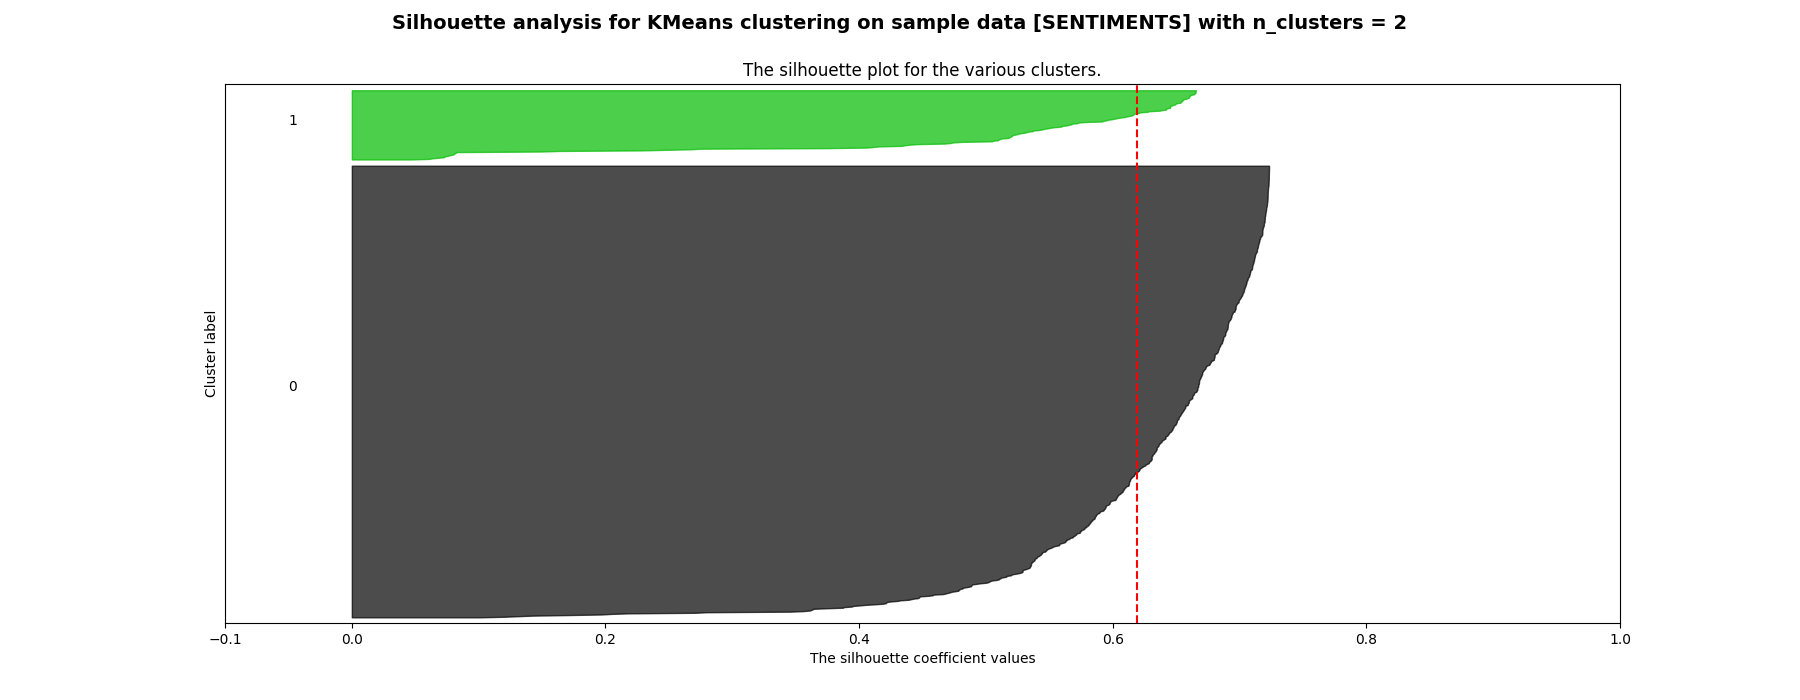

For n_clusters = 2 The average silhouette_score is : 0.619121441674431


<IPython.core.display.Javascript object>


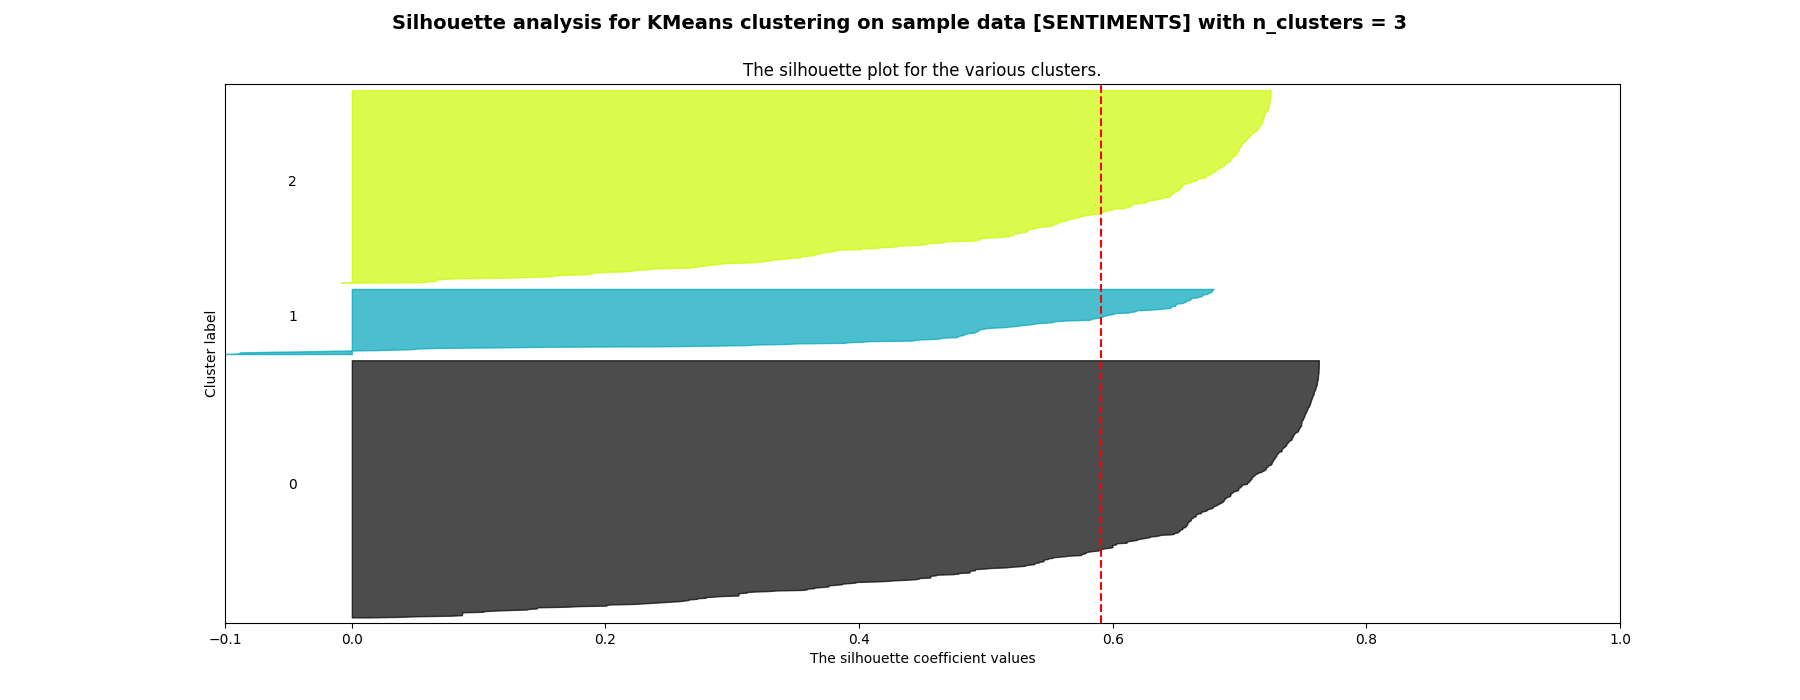

For n_clusters = 3 The average silhouette_score is : 0.5908019042012598


<IPython.core.display.Javascript object>


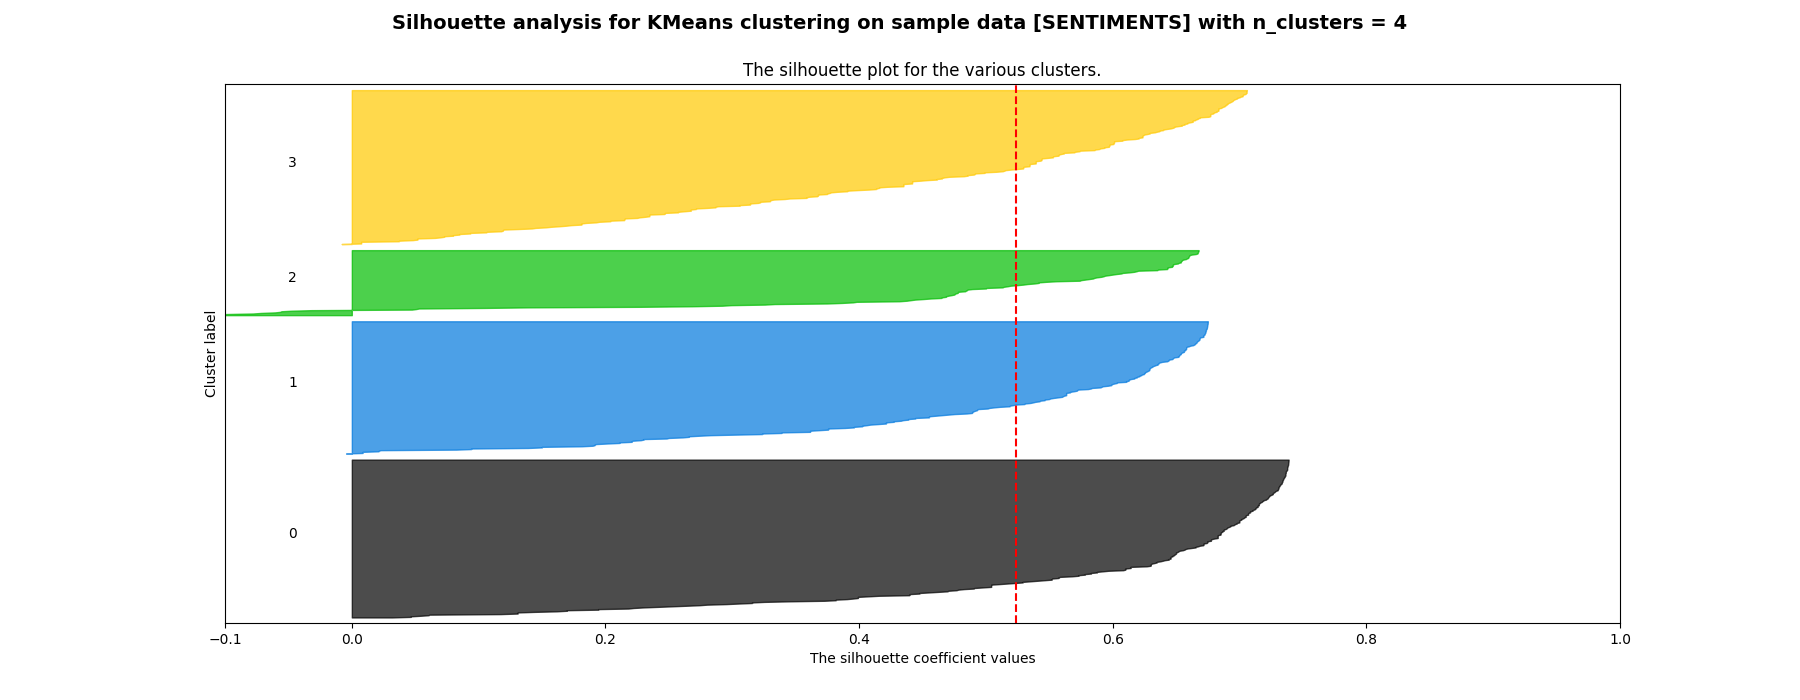

For n_clusters = 4 The average silhouette_score is : 0.523375388097964


<IPython.core.display.Javascript object>


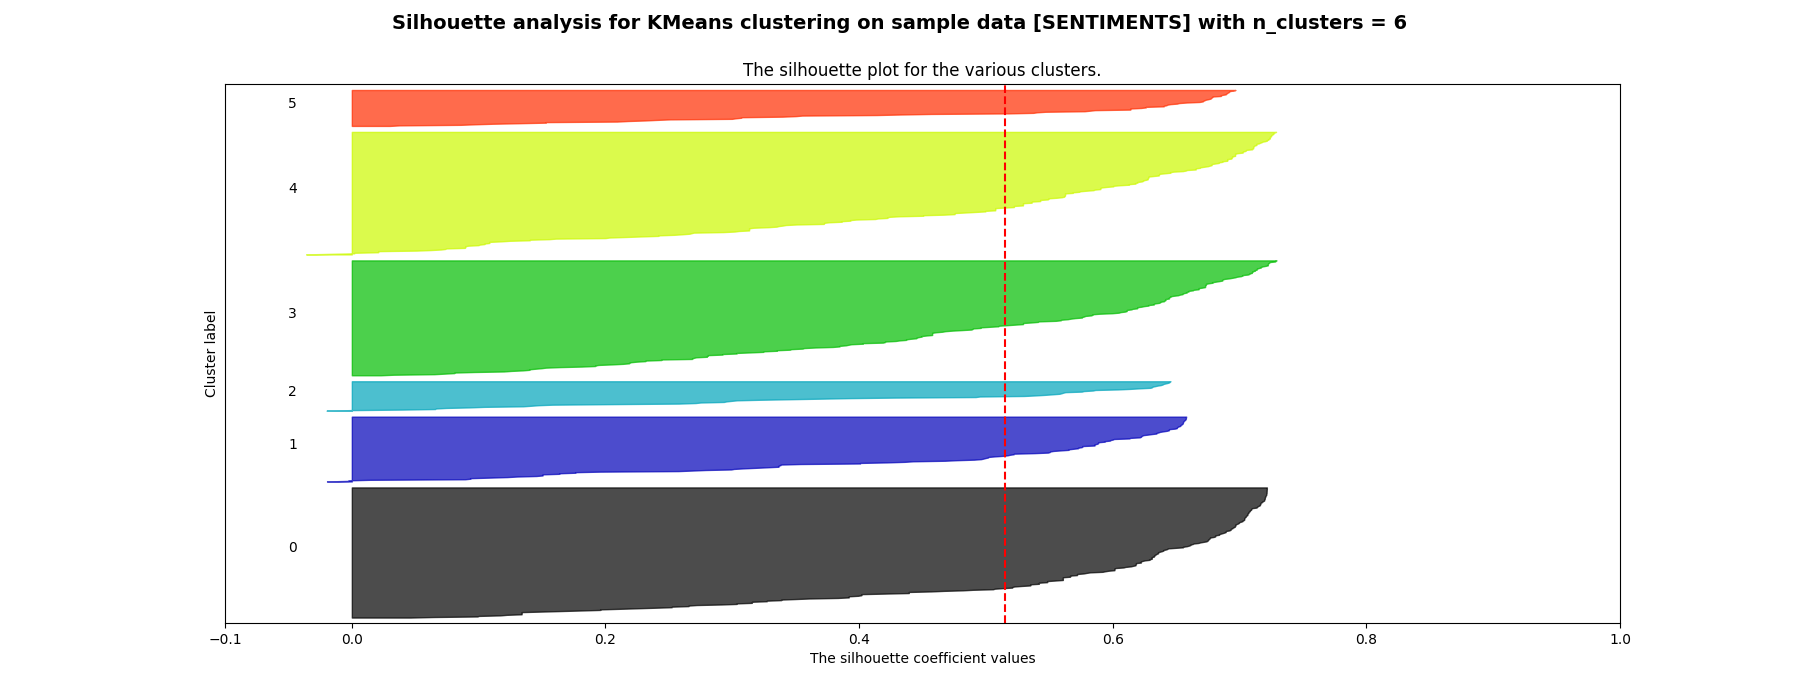

For n_clusters = 6 The average silhouette_score is : 0.5146789410985212


In [36]:
%matplotlib notebook

n_clusters_list = [2,3,4,6]
for n in n_clusters_list:
    n_cluster_kmean =n
    km_s = KMeans(n_clusters=n_cluster_kmean, random_state=10)
    km_s.fit(X_scaled_sentiment.drop(['artists','song_name'], axis=1))
    title = "Silhouette analysis for KMeans clustering on sample data [SENTIMENTS] with n_clusters = %d" % n_cluster_kmean
    print_Silohuette(n_cluster_kmean, km_s.labels_, X_scaled_sentiment.drop(['artists','song_name'], axis=1), title)



In [107]:
k1_nclusters = 4
k2_nclusters = 2
km_n_k1 = KMeans(n_clusters=k1_nclusters, random_state=10)
km_n_k2 = KMeans(n_clusters=k2_nclusters, random_state=10)

sentiment_X_preds_k1 = km_n_k1.fit(X_scaled_sentiment.drop(['artists','song_name'], axis=1)).labels_
sentiment_X_preds_k2 = km_n_k2.fit(X_scaled_sentiment.drop(['artists','song_name'], axis=1)).labels_

sent_song_clusters_k1 = df_features_scale.copy()
sent_song_clusters_k1['cluster'] = sentiment_X_preds_k1

sent_song_clusters_k2 = df_features_scale.copy()
sent_song_clusters_k2['cluster'] = sentiment_X_preds_k2

## PCA on sentiment dataset

<IPython.core.display.Javascript object>


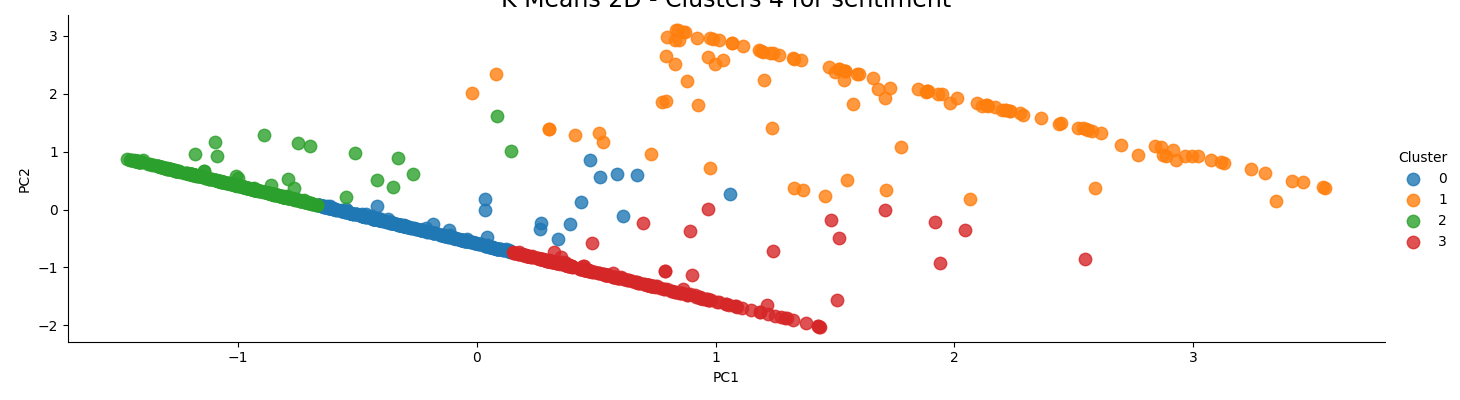

<IPython.core.display.Javascript object>


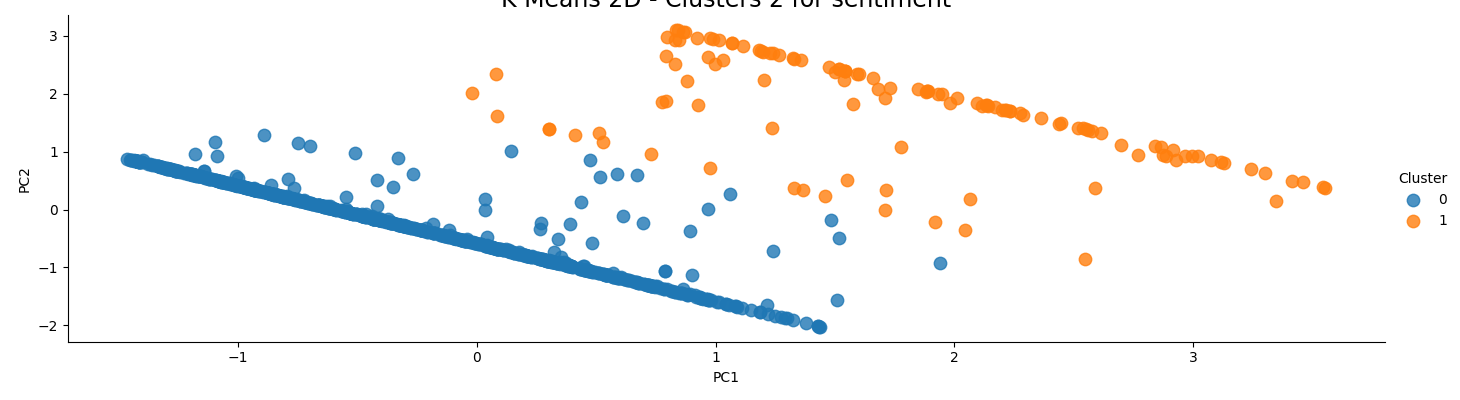

[]

In [46]:
#sentiments
%matplotlib notebook

s_pca_2D = decomposition.PCA(n_components=2, random_state=42)
s_pca_3D = decomposition.PCA(n_components=3, random_state=42)

s_pc_2D = s_pca_2D.fit_transform(X_scaled_sentiment.drop(['artists','song_name'], axis=1))


s_df_pca_2D_k1 = pd.DataFrame(data=s_pc_2D, columns=['PC1', 'PC2'])
s_df_pca_2D_k1['Cluster'] = sentiment_X_preds_k1

s_df_pca_2D_k2 = pd.DataFrame(data=s_pc_2D, columns=['PC1', 'PC2'])
s_df_pca_2D_k2['Cluster'] = sentiment_X_preds_k2

sns.lmplot(x='PC1', y='PC2', data=s_df_pca_2D_k1,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("K Means 2D - Clusters {} for sentiment".format(k1_nclusters), fontsize=17)

sns.lmplot(x='PC1', y='PC2', data=s_df_pca_2D_k2,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("K Means 2D - Clusters {} for sentiment".format(k2_nclusters), fontsize=17)
plt.plot()

## Analisis  de clústeres hechos con sentiment

Primero veamos cómo se comporta Kmeans con n_clusters=4

In [51]:
#sentiments
sent_song_clusters_k1['artists'] = sent_song_clusters_k1['artists'].apply(lambda x: pd.Series(x[0])).stack().reset_index(level=1, drop=True)
s_cluster_1 = sent_song_clusters_k1[sent_song_clusters_k1["cluster"] == 1]
s_cluster_2 = sent_song_clusters_k1[sent_song_clusters_k1["cluster"] == 2]
s_cluster_3 = sent_song_clusters_k1[sent_song_clusters_k1["cluster"] == 3]
s_cluster_4 = sent_song_clusters_k1[sent_song_clusters_k1["cluster"] == 0]

s_clusters = [s_cluster_1,s_cluster_2,s_cluster_3,s_cluster_4]
i = 1
for clus in s_clusters:
    print(f'El cluster {i} tiene {len(clus)} elementos')
    i += 1


El cluster 1 tiene 118 elementos
El cluster 2 tiene 285 elementos
El cluster 3 tiene 239 elementos
El cluster 4 tiene 278 elementos


In [92]:
df_s = sent_song_clusters_k1.copy()
extended_artists = ["Luis Miguel","Chayanne", 'La Oreja de Van Gogh',"Los Piojos","Arca", "Hermetica","Almafuerte", 
           "WOS", "Árbol","Rodrigo", "Damas Gratis", "Mala Fama", "La Mona Jimenez",
          "La Barra", "Raphael",'Andrés Calamaro','Pappo','Callejeros','Daddy Yankee','Calle 13']

df_s_by_artist = df_s.set_index('artists')
sent_dists = distrs_of_clusters_by_artists(artists_list=extended_artists,df=df_s_by_artist)

In [86]:
len(extended_artists)

20

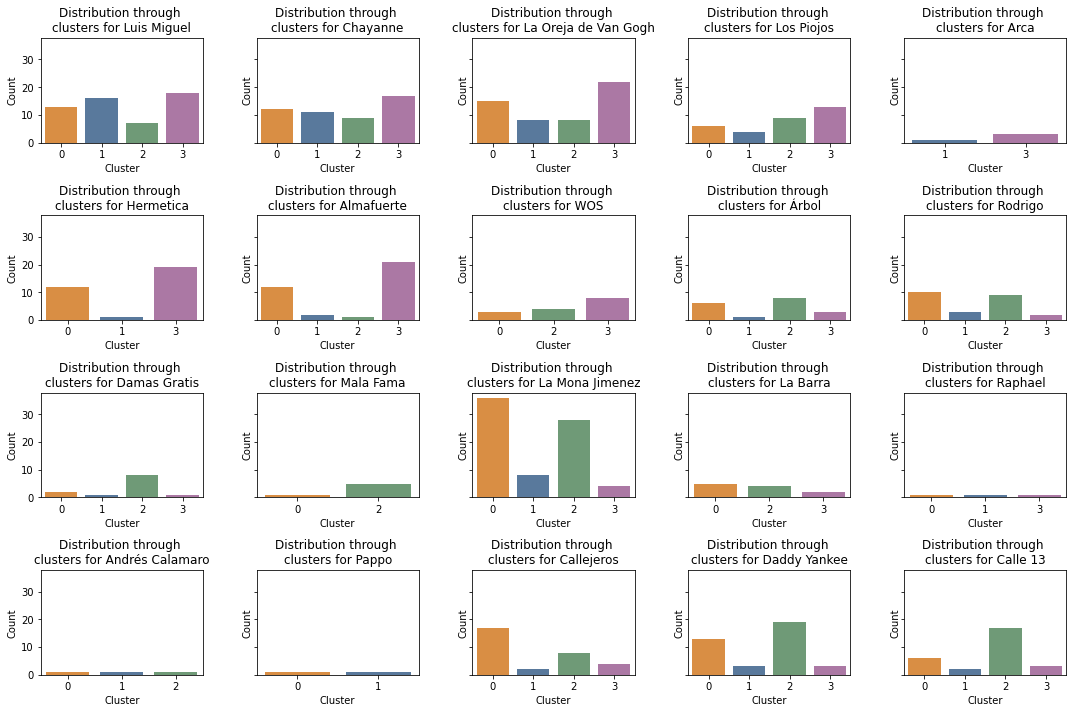

In [93]:
%matplotlib inline
def plot_distrs_of_clusters():
    i=0
    colors = {0: "#F28E2B", 1: "#4E79A7", 2: "#68a172", 3: "#b370aa"}
    fig, axs = plt.subplots(4, 5, figsize=(15,10), sharey=True)
    for j in range(4):
        for k in range(5):
            try:
                values = sent_dists[i].cluster.value_counts().index
                counts = sent_dists[i].cluster.value_counts()
            except:
                break
            sns.barplot(x=values,y=counts,ax=axs[j,k],palette=colors)
            axs[j,k].set_title(f'Distribution through \nclusters for {extended_artists[i]}')
            i+=1
        

    for ax in axs.flat:
        ax.set(xlabel='Cluster', ylabel='Count')
    #fig.delaxes(axs[3,3])
    #fig.delaxes(axs[3,4])
    #fig.delaxes(axs[3,5])
    

#to plot uneven amount of subplots
#for i in range()
#    fig.delaxes(axs[0,4])
    fig.tight_layout(pad=1.05)
    plt.show()
plot_distrs_of_clusters()

#### Observaciones
Las gráficas comparten la escala en el eje Y para poder comparar visualmente la performance del clustering.

Veamos primero los casos más extremos y sobrerrepresentados en el dataset.

Podemos ver ciertas cosas que uno espera encontrar:
- **Luis Miguel** y **Chayanne** tienen una distribución parecida entre ellos: la mayoría de sus canciones pertenecen al **cluster 3, 1 ó 0**, están bastante bien distribuidas en el resto de los clusteres
- **Almafuerte** y **Hermética** tienen una distribución parecida entre ellos: la mayoría de sus canciones pertenecen al **cluster 3, o en segunda instancia al cluster 0**. Prácticamente no tienen canciones pertenecientes al resto de los clústeres, en comparación.
- **Calle 13** y **Daddy Yankee** también: sus canciones pertenecen principalmente al **cluster 2**, y en segunda instancia y en menor medida, pero todavía considerablemente, al **cluster 0**.

Otras situaciones sorprenden:
- **Árbol** y **Rodrigo** tienen casi la misma distribución. En este caso, podemos ver que este clustering excede lo que se entiende como "género" musical, y probablemente hay otras causas latentes respecto a esta división.



Ante un análisis más minucioso pareceria ser que el clustering ante la presencia de 2 features, armó 4 posibles categorías, que corresponden a las permutaciones presentes en el dataset de estas dos características. En nuestro caso:
- Low lyrics_sentiment & Avg-to-High valence (**cluster 0**: letras "negativas", música neutral-a-eufórica)
- High lyrics_sentiment & High valence (**cluster 1**: emociones "positivas" tanto en letras como en música)
- Low-ish lyrics_sentiment, High valence valence (**cluster 2**: letras "negativas"-a-neutrales, música "positiva" -probablemente energética/eufórica/ )
- Low lyrics_sentiment,  Low-ish valence (**cluster 3**: emociones "negativas" tanto en letras como en música)

O sea las permutaciones posibles de estas features (A B, not-A B, A not-B, not-A not-B)

Esto puede servir para sirve para entender las distribuciones afectivas de las canciones de los artistas del dataset, e identificar las tendencias afectivas que podrían llegar a explicar la idea detrás de géneros.

Para ver esta división tomamos bandas que tienen valores a lo largo de todos los clústeres y vimos los valores medios (*mean*) de c/cluster.

In [212]:
clusters_sent = [s_cluster_4, s_cluster_1,s_cluster_2, s_cluster_3]
def compare_across_clusters(*,clusters=clusters_sent, artist='La Oreja de Van Gogh'):
    s = []
    i=0
    print(f'Comparision between clusters for artist: {artist}')
    for cluster in clusters:
        s.append(pd.merge(X_unscaled, cluster, how='inner', on=['song_name']))
        data = s[i][s[i]['artists_y']==artist][['lyrics_sentiment_x','valence_x']].mean()
        print("Cluster ", i , " has: lyrics_sentiment: ",round(data.lyrics_sentiment_x,4), " || valence: ", round(data.valence_x,4))
        i+=1
        
compare_across_clusters()

Comparision between clusters for artist: La Oreja de Van Gogh
Cluster  0  has: lyrics_sentiment:  0.0181  || valence:  0.5434
Cluster  1  has: lyrics_sentiment:  0.8489  || valence:  0.5274
Cluster  2  has: lyrics_sentiment:  0.0317  || valence:  0.7968
Cluster  3  has: lyrics_sentiment:  0.0018  || valence:  0.31


In [213]:
compare_across_clusters(artist='La Mona Jimenez')

Comparision between clusters for artist: La Mona Jimenez
Cluster  0  has: lyrics_sentiment:  0.0103  || valence:  0.6164
Cluster  1  has: lyrics_sentiment:  0.8793  || valence:  0.6431
Cluster  2  has: lyrics_sentiment:  0.0016  || valence:  0.8072
Cluster  3  has: lyrics_sentiment:  0.0001  || valence:  0.3546


Ahora veamos cómo se comporta Kmeans con **n_clusters=2**

In [108]:
#sentiments
sent_song_clusters_k2['artists'] = sent_song_clusters_k2['artists'].apply(lambda x: pd.Series(x[0])).stack().reset_index(level=1, drop=True)
s_cluster_1_b = sent_song_clusters_k2[sent_song_clusters_k2["cluster"] == 0]
s_cluster_2_b = sent_song_clusters_k2[sent_song_clusters_k2["cluster"] == 1]

s_clusters_b = [s_cluster_1_b,s_cluster_2_b]
i = 1
for clus in s_clusters_b:
    print(f'El cluster {i} tiene {len(clus)} elementos')
    i += 1


El cluster 1 tiene 797 elementos
El cluster 2 tiene 123 elementos


In [110]:
df_s_b = sent_song_clusters_k2.copy()
extended_artists = ["Luis Miguel","Chayanne", 'La Oreja de Van Gogh',"Los Piojos","Arca", "Hermetica","Almafuerte", 
           "WOS", "Árbol","Rodrigo", "Damas Gratis", "Mala Fama", "La Mona Jimenez",
          "La Barra", "Raphael",'Andrés Calamaro','Pappo','Callejeros','Daddy Yankee','Calle 13']

df_s_by_artist_b = df_s_b.set_index('artists')
sent_dists_b = distrs_of_clusters_by_artists(artists_list=extended_artists,df=df_s_by_artist_b)

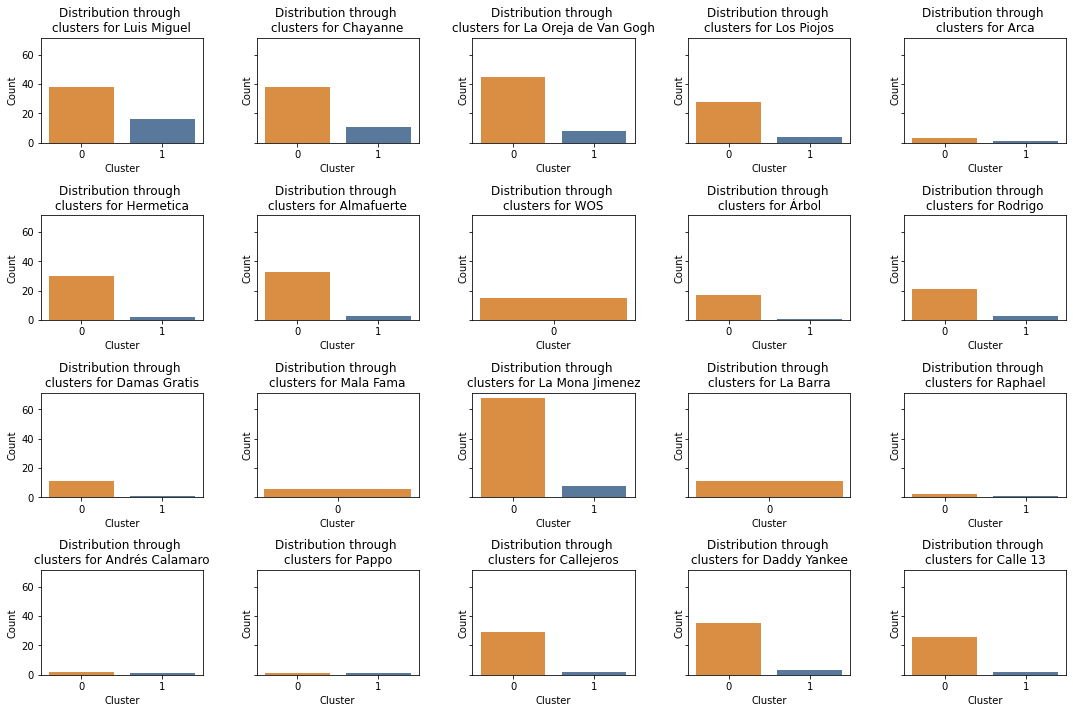

In [114]:
%matplotlib inline
def plot_distrs_of_clusters():
    i=0
    colors = {0: "#F28E2B", 1: "#4E79A7"}
    fig, axs = plt.subplots(4, 5, figsize=(15,10), sharey=True)
    for j in range(4):
        for k in range(5):
            try:
                values = sent_dists_b[i].cluster.value_counts().index
                counts = sent_dists_b[i].cluster.value_counts()
            except:
                break
            sns.barplot(x=values,y=counts,ax=axs[j,k], palette=colors)
            axs[j,k].set_title(f'Distribution through \nclusters for {extended_artists[i]}')
            i+=1
        

    for ax in axs.flat:
        ax.set(xlabel='Cluster', ylabel='Count')
    #fig.delaxes(axs[3,3])
    #fig.delaxes(axs[3,4])
    #fig.delaxes(axs[3,5])
    

#to plot uneven amount of subplots
#for i in range()
#    fig.delaxes(axs[0,4])
    fig.tight_layout(pad=1.05)
    plt.show()
plot_distrs_of_clusters()

#### Observaciones

Vemos que en este caso la división por género no fue relevante a la hora de armar estos clústers. Intentemos encontrar una posible causa latente de esta primera división.

In [123]:
s_cluster_1_b['artists'].value_counts()[:5]

La Mona Jimenez         68
La Oreja de Van Gogh    45
Luis Miguel             38
Chayanne                38
Daddy Yankee            35
Name: artists, dtype: int64

In [122]:
s_cluster_2_b['artists'].value_counts()[:5]

Luis Miguel             16
Chayanne                11
La Oreja de Van Gogh     8
La Mona Jimenez          8
Eruca Sativa             7
Name: artists, dtype: int64

In [169]:
s_cluster_1_b[s_cluster_1_b['artists'] == "Luis Miguel"].sample(3)

,lyrics_sentiment,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,song_name,artists,cluster
134,-0.416580,-1.380205,0.002507,1.313656,0.770673,0.779995,-0.579066,0.050320,-0.177158,-0.442458,-1.378233,0.976242,La Incondicional,Luis Miguel,0
165,-0.408896,0.295618,-0.582519,-0.383765,-0.157845,-1.282060,-0.695297,0.737224,-0.177087,-0.723149,-0.359137,-1.171171,La Gloria Eres Tu,Luis Miguel,0
152,-0.416580,-0.688595,-0.368759,-0.949572,0.337536,0.779995,-0.362525,0.595550,-0.177158,-0.457415,-2.043051,-1.365143,Si tú te atreves,Luis Miguel,0


Tomemos el caso de la Oreja de Van Gogh y Luis Miguel.